# How to Train RF-DETR Object Detection on a Custom Dataset

In [1]:
!nvidia-smi

Thu Jan 29 19:49:19 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070 Ti     Off |   00000000:02:00.0  On |                  N/A |
|  0%   44C    P0             48W /  300W |    1231MiB /  16303MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


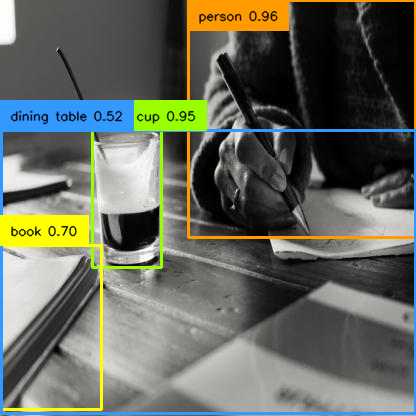

In [2]:
import numpy as np
import supervision as sv

from PIL import Image

from rfdetr import RFDETRMedium
from rfdetr.util.coco_classes import COCO_CLASSES

# Custom class names from your trained dataset
CUSTOM_CLASSES = ['pen', 'Pen']

image = Image.open("dataset/valid/00cd18c5aff4548b_jpg.rf.bd1663cdc9106926c3d3507ce963788f.jpg")

model = RFDETRMedium(resolution=640)
model.optimize_for_inference()

detections = model.predict(image, threshold=0.5)

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    smart_position=True
)

labels = [
    f"{COCO_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = bbox_annotator.annotate(annotated_image, detections)
annotated_image = label_annotator.annotate(annotated_image, detections, labels)
annotated_image.thumbnail((800, 800))
annotated_image

```
└── dataset
    ├── test
    │   ├── 0085364b2034b946_jpg.rf.70ae3ded7dadaec0f83fa75a1ca97a1b.jpg
    │   ├── 00cd18c5aff4548b_jpg.rf.bd1663cdc9106926c3d3507ce963788f.jpg
    │   └── _annotations.coco.json
    ├── train
    │   ├── 000fcbfa875b9eb2_jpg.rf.2fa47d1e61228c5f856a69c1c51e46ac.jpg
    │   ├── 000fcbfa875b9eb2_jpg.rf.3ab8fc8b5e049dad298b5f84e46d12cc.jpg
    │   └── _annotations.coco.json
    └── valid
        ├── 0085364b2034b946_jpg.rf.70ae3ded7dadaec0f83fa75a1ca97a1b.jpg
        ├── 00cd18c5aff4548b_jpg.rf.bd1663cdc9106926c3d3507ce963788f.jpg
        └── _annotations.coco.json

```

In [ ]:
from rfdetr import RFDETRMedium

model = RFDETRMedium()

model.train(dataset_dir="dataset", epochs=10, batch_size=8, grad_accum_steps=2)

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights
Unable to initialize TensorBoard. Logging is turned off for this session.  Run 'pip install tensorboard' to enable logging.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=2, grad_accum_steps=2, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=8, weight_decay=0.0001, epochs=50, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-medium.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=N

fatal: ambiguous argument 'HEAD': unknown revision or path not in the working tree.
Use '--' to separate paths from revisions, like this:
'git <command> [<revision>...] -- [<file>...]'


Epoch: [0]  [ 0/50]  eta: 0:00:56  lr: 0.000100  class_error: 0.00  loss: 11.9741 (11.9741)  loss_ce: 1.3165 (1.3165)  loss_bbox: 0.4895 (0.4895)  loss_giou: 0.5721 (0.5721)  loss_ce_0: 1.2956 (1.2956)  loss_bbox_0: 0.5553 (0.5553)  loss_giou_0: 0.6355 (0.6355)  loss_ce_1: 1.2804 (1.2804)  loss_bbox_1: 0.4669 (0.4669)  loss_giou_1: 0.5598 (0.5598)  loss_ce_2: 1.3039 (1.3039)  loss_bbox_2: 0.4933 (0.4933)  loss_giou_2: 0.5828 (0.5828)  loss_ce_enc: 1.2570 (1.2570)  loss_bbox_enc: 0.5952 (0.5952)  loss_giou_enc: 0.5701 (0.5701)  loss_ce_unscaled: 1.3165 (1.3165)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0979 (0.0979)  loss_giou_unscaled: 0.2861 (0.2861)  cardinality_error_unscaled: 2.0000 (2.0000)  loss_ce_0_unscaled: 1.2956 (1.2956)  loss_bbox_0_unscaled: 0.1111 (0.1111)  loss_giou_0_unscaled: 0.3178 (0.3178)  cardinality_error_0_unscaled: 1.5000 (1.5000)  loss_ce_1_unscaled: 1.2804 (1.2804)  loss_bbox_1_unscaled: 0.0934 (0.0934)  loss_giou_1_unscaled: 0.2799 (0.2799

Test:  [0/4]  eta: 0:00:01  class_error: 0.00  loss: 9.4199 (9.4199)  loss_ce: 0.8320 (0.8320)  loss_bbox: 0.4381 (0.4381)  loss_giou: 0.3505 (0.3505)  loss_ce_0: 0.9375 (0.9375)  loss_bbox_0: 0.5032 (0.5032)  loss_giou_0: 0.4184 (0.4184)  loss_ce_1: 0.9766 (0.9766)  loss_bbox_1: 0.4776 (0.4776)  loss_giou_1: 0.4007 (0.4007)  loss_ce_2: 0.8555 (0.8555)  loss_bbox_2: 0.4458 (0.4458)  loss_giou_2: 0.3689 (0.3689)  loss_ce_enc: 0.9023 (0.9023)  loss_bbox_enc: 0.9296 (0.9296)  loss_giou_enc: 0.5832 (0.5832)  loss_ce_unscaled: 0.8320 (0.8320)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0876 (0.0876)  loss_giou_unscaled: 0.1753 (0.1753)  cardinality_error_unscaled: 1.6250 (1.6250)  loss_ce_0_unscaled: 0.9375 (0.9375)  loss_bbox_0_unscaled: 0.1006 (0.1006)  loss_giou_0_unscaled: 0.2092 (0.2092)  cardinality_error_0_unscaled: 1.6250 (1.6250)  loss_ce_1_unscaled: 0.9766 (0.9766)  loss_bbox_1_unscaled: 0.0955 (0.0955)  loss_giou_1_unscaled: 0.2004 (0.2004)  cardinality_error_1_

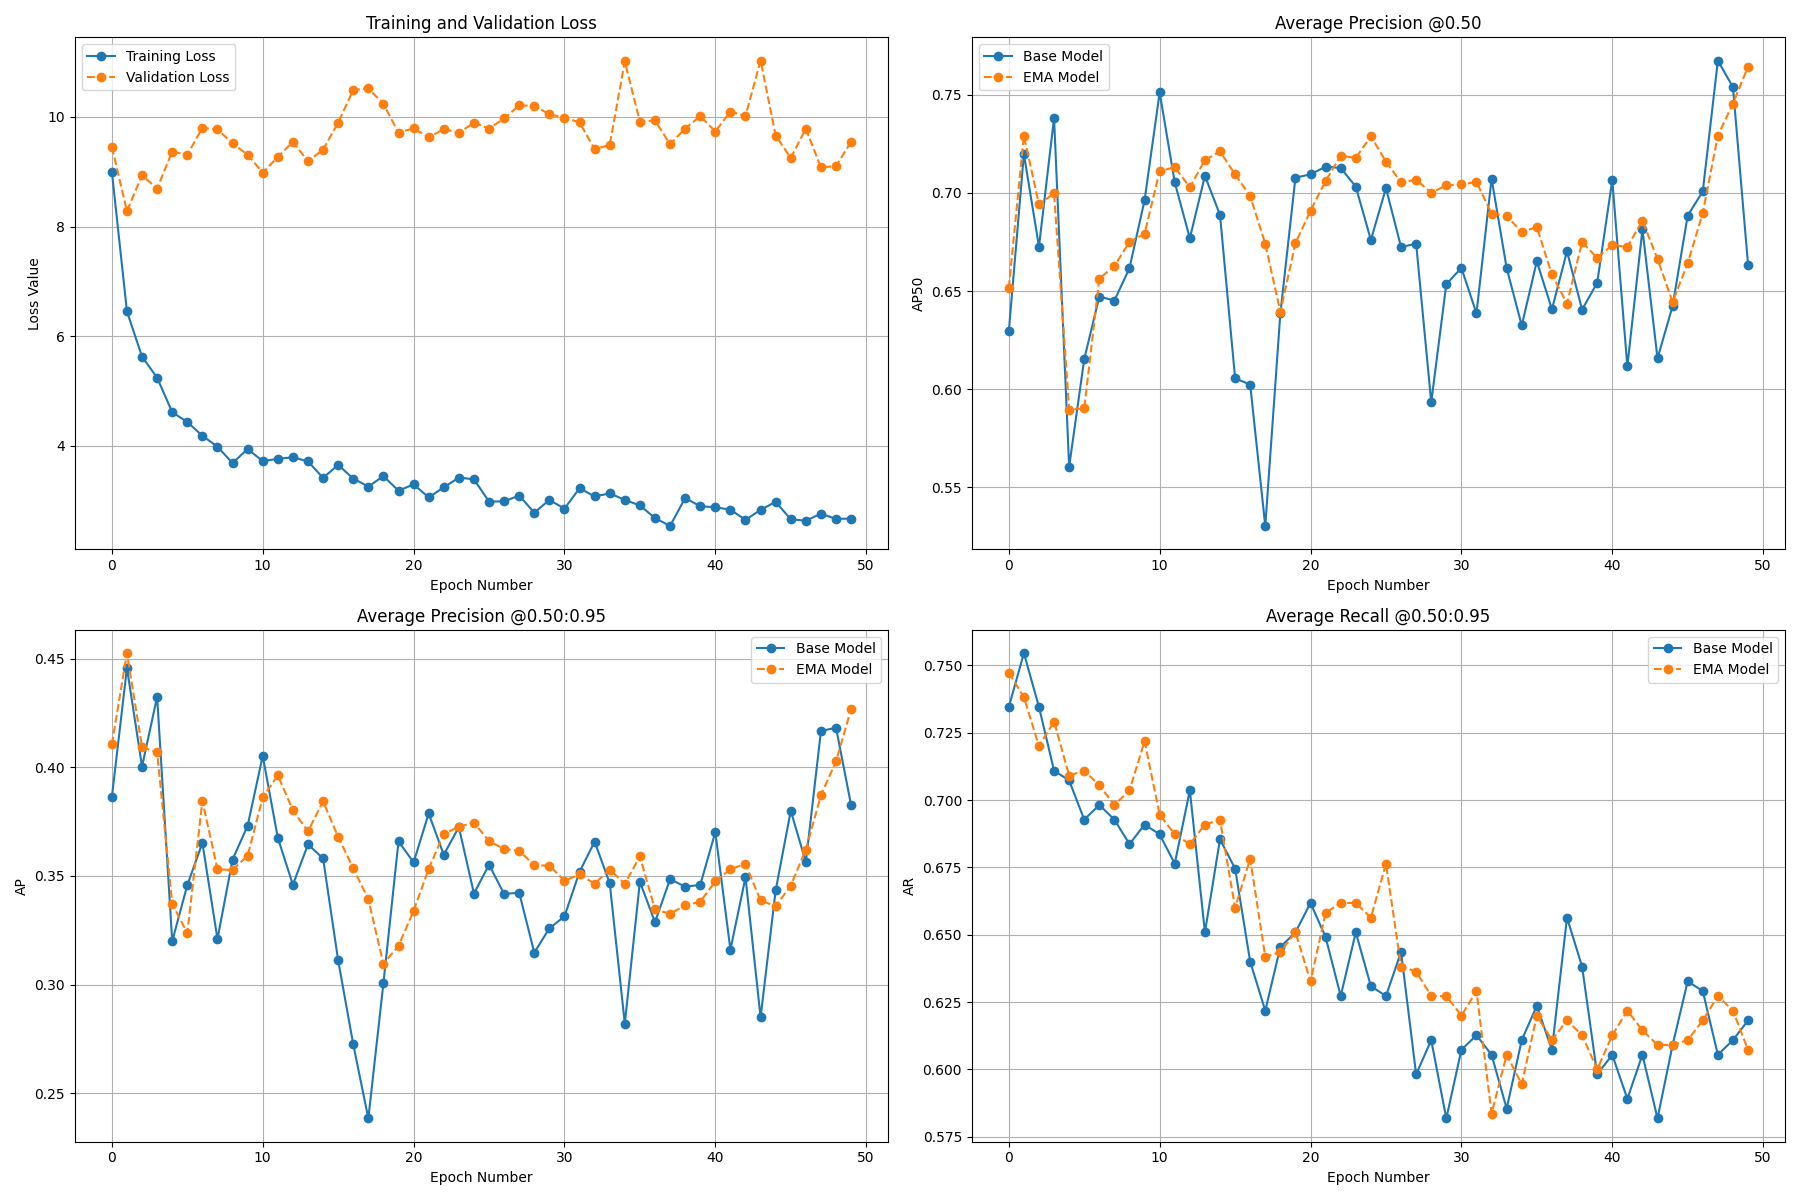

In [9]:
from PIL import Image

Image.open("output/metrics_plot.png")

# Test accuracy

In [10]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path="dataset/test",
    annotations_path="dataset/test/_annotations.coco.json",
)

In [11]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 30/30 [00:00<00:00, 57.19it/s]


In [12]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.461
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.731
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.547
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.177
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.308
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.521


# Inference

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights
Detections(xyxy=array([[222.03403 ,  54.445316, 307.3478  , 235.55057 ]], dtype=float32), mask=None, confidence=array([0.77196556], dtype=float32), class_id=array([1]), tracker_id=None, data={}, metadata={})


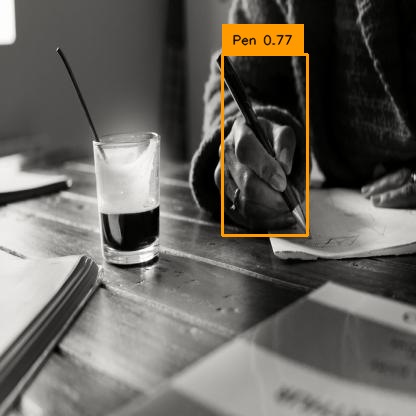

In [13]:
model = RFDETRMedium(pretrain_weights="output/checkpoint_best_total.pth")
model.optimize_for_inference()

image = Image.open("dataset/valid/00cd18c5aff4548b_jpg.rf.bd1663cdc9106926c3d3507ce963788f.jpg")

detections = model.predict(image, threshold=0.5)

print(detections)

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    smart_position=True
)

labels = [
    f"{CUSTOM_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = bbox_annotator.annotate(annotated_image, detections)
annotated_image = label_annotator.annotate(annotated_image, detections, labels)
annotated_image.thumbnail((800, 800))
annotated_image